In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from time import time
import os

In [2]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

## 超参数设置

In [3]:
# parameters for padding sequence
max_len = 120
trunc_type = 'post'

## 数据读取

In [4]:
train_file_path = './data/train_set.csv'
train_df = pd.read_csv(train_file_path, sep='\t')
print(train_df.shape)

(200000, 2)


In [5]:
train_y = pd.get_dummies(train_df['label']).values
train_y.shape

(200000, 14)

## 文本处理

文本按最大长度为max_len进行截取或补齐

In [6]:
def text2seq(line: str):
    line = line.split(' ')
    line = [int(word) for word in line]
    return line

t0 = time()
train_x = train_df['text'].apply(text2seq).values
train_x = pad_sequences(train_x, maxlen=max_len, truncating=trunc_type, dtype='int16')
print('Processing time(s):', time()-t0)
train_x.shape

Processing time(s): 38.630300760269165


(200000, 120)

## 构建深度学习模型

In [7]:
def train_model(model: tf.keras.Model):
    t0 = time()
    callback = EarlyStopping(patience=3)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[callback])
    print('processing time(min):', (time()-t0)/60)
    plot_acc_and_loss(history.history)


def plot_acc_and_loss(history):
    train_acc, test_acc = history['acc'], history['val_acc']
    train_loss, test_loss = history['loss'], history['val_loss']
    x = np.arange(len(train_acc))

    fig, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(x, train_acc, 'r', label='train_acc')
    ax[0].plot(x, test_acc, 'b', label='test_acc')
    ax[1].plot(x, train_loss, 'r', label='train_loss')
    ax[1].plot(x, test_loss, 'b', label='val_loss')
    
    for axis in ax:
        axis.set_xlabel('Epochs')
        axis.grid(axis='y')
        axis.legend()
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')


def predict_and_save(model: tf.keras.Model):
    t0 = time()
    test_file_path = './data/test_a.csv'
    test_df = pd.read_csv(test_file_path, sep='\t')
    test_x = test_df['text'].apply(text2seq).values
    test_x = pad_sequences(test_x, maxlen=max_len, truncating=trunc_type, dtype='int16')
    test_y = model.predict(test_x)
    print(test_y.shape)
    test_label = np.argmax(test_y, axis=1)
    pd.Series(data=test_label, name='label').to_csv('./data/test_a_submit.csv', index=False)
    print('saving complete')
    print('processing time(s):', time()-t0))
    

### 全连接层模型

将全连接层模型得到的结果作为baseline， 该模型在验证集上的表现约为90.5~91%

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           128000    
_________________________________________________________________
flatten (Flatten)            (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                61472     
_________________________________________________________________
dense_1 (Dense)              (None, 14)                462       
Total params: 189,934
Trainable params: 189,934
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
5000/5000 [==============================] - 13s 3ms/step - loss: 0.4635 - acc: 0.8622 - val_loss: 0.2964 - val_acc: 0.9112
Epoch 2/10
5000/5000 [==============================] - 14s 3ms/step - loss: 0.2421 - acc: 0.9269 - val_loss: 0.3

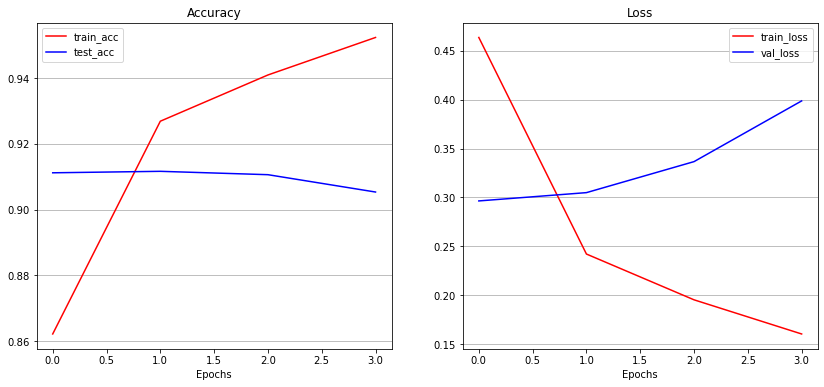

In [8]:
# parameters for baseline model
vocab_size = 8000
embed_dim = 16
epochs = 10
batch_size = 32

baseline_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(14, activation='softmax')
])

baseline_model.summary()
train_model(baseline_model)

### LSTM模型

构建双层LSTM模型进行训练，该模型训练时间很长，但其在验证集上的表现是有提升的，约为93%

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 32)           256000    
_________________________________________________________________
lstm (LSTM)                  (None, 120, 32)           8320      
_________________________________________________________________
dropout (Dropout)            (None, 120, 32)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 14)                462       
Total params: 273,102
Trainable params: 273,102
Non-trainable params: 0
________________________________________________

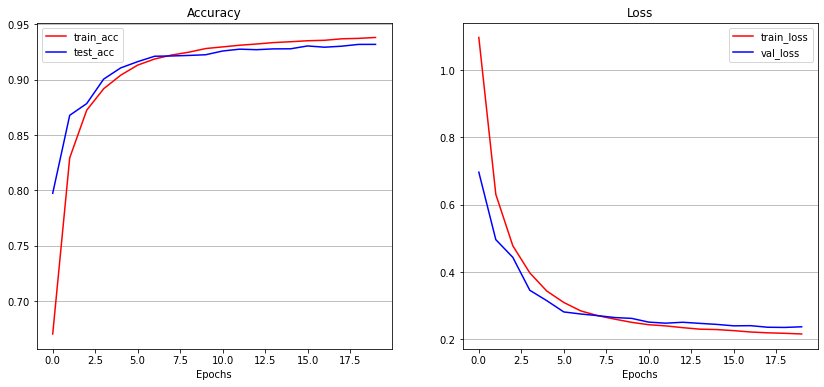

In [9]:
# parameters for model training
vocab_size = 8000
embed_dim = 32
epochs = 20
batch_size = 32

lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=max_len),
    LSTM(32,return_sequences=True, dropout=0.1, recurrent_dropout=0.4),
    Dropout(0.2),
    LSTM(32, dropout=0.1, recurrent_dropout=0.4),
    Dropout(0.2),
    Dense(14, activation='softmax')
])

lstm_model.summary()
train_model(lstm_model)

## 模型保存

In [11]:
lstm_model.save('./models/lstm_val93.h5')
print('saving complete')

saving complete


## 生成测试结果

生成测试集结果，并提交天池，准确率为91.9%

In [12]:
predict_and_save(lstm_model)

(50000, 14)
saving complete
processing time(s): 1.8078851580619812
